In [1]:
import numpy as np
import pandas as pd
import joblib
from pathlib import Path

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

ARTIF_DIR = Path("../app/artifacts")
DATA_DIR = Path("../data")

df = pd.read_csv(DATA_DIR / "df_file.csv")
print(df.shape, df["Label"].value_counts())


(2225, 2) Label
1    511
4    510
0    417
2    401
3    386
Name: count, dtype: int64


In [2]:
tfidf = joblib.load(ARTIF_DIR / "tfidf.pkl")        # vectorizer
pipe  = joblib.load(ARTIF_DIR / "knn_clf.pkl")      # TFIDF + KNN (classifier)
index = joblib.load(ARTIF_DIR / "knn_index.pkl")    # NearestNeighbors (retrieval)

# nhất quán pre-clean nhẹ
texts = df["Text"].astype(str).str.replace("\n", " ").str.strip().tolist()
labels = df["Label"].values
Xvec   = tfidf.transform(texts)


In [3]:
terms = np.array(tfidf.get_feature_names_out())

def top_tfidf_for_doc(row_csr, topk=10):
    coo = list(zip(row_csr.indices, row_csr.data))
    coo_sorted = sorted(coo, key=lambda x: x[1], reverse=True)[:topk]
    return [(terms[i], float(w)) for i, w in coo_sorted]

np.random.seed(42)
sample_ids = np.random.choice(len(texts), size=3, replace=False)

for sid in sample_ids:
    row = Xvec[sid]
    top_terms = top_tfidf_for_doc(row, topk=12)
    print(f"\n=== Document #{sid} (label={labels[sid]}) ===")
    print(texts[sid][:200] + ("..." if len(texts[sid])>200 else ""))
    for w, s in top_terms:
        print(f"  {w:25s}  {s:.3f}")



=== Document #414 (label=0) ===
David Blunkett in quotes    David Blunkett - who has resigned as home secretary - built his reputation as a plain-speaking Yorkshire man.          I fell in love with someone and they wouldn't go publ...
  plain speaking             0.169
  blunkett                   0.153
  plain                      0.148
  david blunkett             0.124
  terrorism                  0.113
  accept                     0.107
  committed                  0.106
  celebrity edition          0.104
  fell love                  0.104
  foolishly                  0.104
  got think                  0.104
  love wouldn                0.104

=== Document #420 (label=1) ===
Benitez issues warning to Gerrard    Liverpool manager Rafael Benitez has ordered captain Steven Gerrard not to play down their Champions League ambitions and be more positive.    Gerrard told the BBC...
  benitez                    0.262
  win trophy                 0.218
  gerrard                    0.207
 

In [4]:
# chọn 1 văn bản làm "query doc"
q_id = int(sample_ids[0])
qv = Xvec[q_id]
sims = cosine_similarity(qv, Xvec).ravel()  # similarity với toàn corpus

# Lấy top-k gần nhất (loại bỏ chính nó)
k = 5
top_idx = np.argsort(-sims)
top_idx = top_idx[top_idx != q_id][:k]
pd.DataFrame({
    "similarity": sims[top_idx],
    "label": labels[top_idx],
    "snippet": [texts[i][:180] + ("..." if len(texts[i])>180 else "") for i in top_idx],
})


,similarity,label,snippet
0,0.270981,0,Blunkett tells of love and pain David Blunk...
1,0.118381,0,Blair 'damaged' by Blunkett row A majority ...
2,0.113448,0,Profile: David Blunkett Before he resigned ...
3,0.102625,0,Blair's hope for Blunkett return The events...
4,0.092539,0,Blunkett unveils policing plans People coul...


In [5]:
# tách bước trong pipeline
vec = pipe.named_steps["tfidfvectorizer"]
knn = pipe.named_steps["kneighborsclassifier"]

qv_clf = vec.transform([texts[q_id]])
dist, idx = knn.kneighbors(qv_clf, n_neighbors=5, return_distance=True)
sim = 1 - dist[0]

knn_tbl = pd.DataFrame({
    "Similarity": sim,
    "Label": labels[idx[0]],
    "Snippet": [texts[i][:180] + ("..." if len(texts[i])>180 else "") for i in idx[0]]
})
print("Predicted label (majority vote):", int(pipe.predict([texts[q_id]])[0]))
knn_tbl


Predicted label (majority vote): 0


,Similarity,Label,Snippet
0,1.000000,0,David Blunkett in quotes David Blunkett - w...
1,0.270981,0,Blunkett tells of love and pain David Blunk...
2,0.118381,0,Blair 'damaged' by Blunkett row A majority ...
3,0.113448,0,Profile: David Blunkett Before he resigned ...
4,0.102625,0,Blair's hope for Blunkett return The events...


In [6]:
query = "election campaign and budget policy"
qv = tfidf.transform([query])
dist, idx = index.kneighbors(qv, n_neighbors=5, return_distance=True)
sim = 1 - dist[0]

pd.DataFrame({
    "Similarity": sim,
    "Label": labels[idx[0]],
    "Snippet": [texts[i][:200] + ("..." if len(texts[i])>200 else "") for i in idx[0]]
})


,Similarity,Label,Snippet
0,0.153981,0,Labour MP praises Tory campaign The Conserv...
1,0.149486,0,Howard attacks 'pay later' Budget Tory lead...
2,0.146538,0,Brown's poll campaign move denied The gover...
3,0.146304,0,Labour's four little words Labour has unvei...
4,0.139733,0,Brown comes out shooting Labour may have ab...


In [7]:
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)

# dự đoán bằng pipeline đã fit full (minh họa), chuẩn nhất là refit trên Xtr rồi đánh giá Xte
preds = pipe.predict(Xte)
acc = accuracy_score(yte, preds)
f1  = f1_score(yte, preds, average="macro")

print(f"Hold-out ACC: {acc:.4f} | Macro-F1: {f1:.4f}")
print(classification_report(yte, preds))


Hold-out ACC: 0.9820 | Macro-F1: 0.9817
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        84
           1       0.99      1.00      1.00       102
           2       0.95      0.99      0.97        80
           3       1.00      0.97      0.99        77
           4       1.00      0.95      0.97       102

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



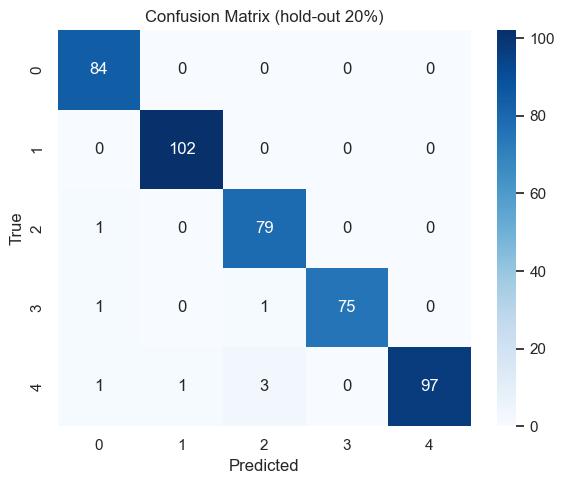

In [8]:
cm = confusion_matrix(yte, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (hold-out 20%)")
plt.tight_layout()
plt.show()


In [9]:
OUT_DIR = ARTIF_DIR / "metrics_showcase"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Lưu bảng KNN neighbors, VSM search và CM
knn_tbl.to_csv(OUT_DIR / "knn_neighbors_example.csv", index=False)

# lưu 5 kết quả search từ Cell 6
search_tbl = pd.DataFrame({
    "Similarity": sim,
    "Label": labels[idx[0]],
    "Snippet": [texts[i][:200] + ("..." if len(texts[i])>200 else "") for i in idx[0]]
})
search_tbl.to_csv(OUT_DIR / "vsm_search_example.csv", index=False)

# lưu classification report + scores
with open(OUT_DIR / "holdout_classification_report.txt", "w", encoding="utf-8") as f:
    f.write(f"ACC={acc:.4f}, Macro-F1={f1:.4f}\n\n")
    f.write(classification_report(yte, preds))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (hold-out 20%)")
plt.tight_layout()
plt.savefig(OUT_DIR / "confusion_matrix.png", dpi=160)
plt.close()

print("Saved to:", OUT_DIR)


Saved to: ..\app\artifacts\metrics_showcase
